# Clustering
- 주어진 데이터를 사용하여, 전체를 몇 개의 유사한 집단으로 그룹화하여 특징 파악
    - Hard: 각 샘플에 대해 가장 가까운 클러스터 선택
    - Soft: 클러스터마다 샘플에 클러스터 점수 부여
- 모든 변수를 고려하므로, 적절한 변수 선택이 필요함

In [1]:
import warnings
from IPython.display import display, HTML

In [2]:
### HTML display 조정
display(HTML("<style>.container {width :98% !important;}</style>"))

### Warning 제거
warnings.filterwarnings('ignore')

## Package load

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import fetch_openml

from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

## Distance Metrics
- Clustering의 기준이 되는 지표들
- Numeric
    - 수학적: Euclidean, Manhattan, Chebyshev, Minkowski, Canberra, Cosine
    - 통계적: Standardized, Mahalanobis, Pearson, Jensen-Shannon
- Categorical
    - Jaccard, Dice, Hamming
- Mixed: Gower

In [5]:
from scipy.spatial import distance

### (1) Numeric

In [6]:
a = np.array((1, 2, 3, 4))
b = np.array((1, 1, 1, 3))

#### Euclidean
- 벡터 좌표 차이 제곱합의 제곱근
- L2 distance
- 변수들을 각 변수의 표준편차로 scaling한 경우 Standardized Euclidean

In [7]:
distance.euclidean(a, b)

2.449489742783178

#### Manhattan (Cityblock)
- 벡터 좌표 차이의 절대값 합
- L1 diatance
- 도시에서 건물과 건물 사이 거리를 계산하기 위해 고안되었음

In [8]:
distance.cityblock(a, b)

4

#### Chebyshev
- 각 dimension의 Manhattan 거리 중 최대값

In [9]:
distance.chebyshev(a, b)

2

#### Canberra
- 가중 절대값

In [10]:
distance.canberra(a, b)

0.976190476190476

#### Minkowski
- Manhattan / Euclidean 거리의 일반화
- 벡터 좌표 차이의 n제곱합에 n제곱근을 취한 것

In [11]:
distance.minkowski(a, b)

2.449489742783178

#### Cosine
- Cosine similarity: 벡터 내적의 cosine 값(방향각)으로, 서로 같을수록 1, 다를수록 -1 값을 가지게 됨
- Cosine distance = 1 - Consine similarity
- 문서를 유사도 기준으로 분류/그룹화할 때 주로 사용

In [12]:
distance.cosine(a, b)

0.05131670194948623

#### Pearson
- 선형 관계를 나타내는 Pearson correlation의 역수

In [13]:
distance.correlation(a, b)
# 1 - pd.DataFrame([a, b]).T.corr()[1][0]

0.2254033307585166

#### Mahalanobis
- 변수들의 산포를 고려하여 이를 표준화한 거리
- 두 벡터 사이의 거리를 표본공분산으로 나누어 표준화
- 표본공분산을 구해야 하므로, 그룹에 대한 사전 지식이 필요함

In [14]:
iv = [[1, 0.5, 0.5, 1], [0.5, 1, 0.5, 1], [0.5, 0.5, 1, 1], [1, 1, 1, 1]] # inverse of cov matrix
distance.mahalanobis(a, b, iv)

3.7416573867739413

#### Standardized
- 공분산 행렬에서 대각 원소(표본표준편차)만 존재하는 경우로, Mahalanobis의 특수 케이스

In [15]:
iv = [[0.5, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0.5, 0], [0, 0, 0, 1]] # inverse of sample variance(diag) matrix
distance.mahalanobis(a, b, iv)

2.0

#### Jensen-Shannon
- Jensen-Shannon divergence의 제곱근
- Kullback-Leibler divergence: 하나의 확률 분포 P가 두 번째 기준 확률 분포 Q 와 어떻게 다른지 에 대한 척도
- Jensen-Shannon divergence: Kullback-Leibler divergence의 대칭화 및 평활화된 버전

In [16]:
distance.jensenshannon(a, b)

0.13195130923594142

### (2) Categorical

In [17]:
a = np.array((1, 0, 1, 1, 1))
b = np.array((1, 0, 0, 0, 1))

#### Jaccard
- 합집합에서 교집합 영역의 비율: A와 B의 교집합 / A와 B의 합집합
- 0~1 사이의 값

In [18]:
distance.jaccard(a, b)

0.5

#### Dice
- 2*(A와 B 교집합)/A 영역 + B 영역

In [19]:
distance.dice(a, b)

0.3333333333333333

#### Hamming
- 같은 위치에서, 서로 다른 원소의 개수

In [20]:
distance.hamming(a, b)

0.4

### (3) Oridinal

In [21]:
a = np.array((1, 2, 3, 4))
b = np.array((1, 3, 4, 8))

In [22]:
### Rank Correlation distance
# Spearman 상관계수의 역수
1 - pd.DataFrame([a, b]).T.corr(method='spearman')[1][0]

0.0

### (4) Mixed
- Gower: 수치형+범주형 모든 변수가 0-1 사이에 오도록 함
    - 수치형은 Manhattan, 범주형은 다르면 1, 같으면 0

In [23]:
# !pip install gower
import gower

In [24]:
loan_data = pd.read_csv("./dataset/loan_data.csv.gz")
defaults = loan_data.loc[loan_data['outcome']=='default', ]

x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]

In [25]:
gower.gower_matrix(x)

array([[0.        , 0.62204784, 0.6863877 , 0.632904  , 0.37727892],
       [0.62204784, 0.        , 0.8143398 , 0.7608561 , 0.5389727 ],
       [0.6863877 , 0.8143398 , 0.        , 0.43070832, 0.30910876],
       [0.632904  , 0.7608561 , 0.43070832, 0.        , 0.505625  ],
       [0.37727892, 0.5389727 , 0.30910876, 0.505625  , 0.        ]],
      dtype=float32)

## Cluster Evaluation Metrics
- 군집의 타당성 평가
- 군집 개수 선정에 활용되기도 함

In [26]:
iris = load_iris()
iris = pd.DataFrame(iris.data, columns=iris.feature_names)
iris['Class'] = load_iris().target

In [27]:
feature = iris.iloc[:, :4]
feature.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [29]:
scaler = StandardScaler()
scaled_feature = scaler.fit_transform(feature)

km = KMeans(n_clusters=3, random_state=1).fit(scaled_feature)
cluster = km.predict(scaled_feature)

### (1) Unsupervised
- Silhouette coefficient
    - 각 군집 간의 거리가 얼마나 효율적으로 분리되어 있는지 판단
    - 군집 간 분리도와 군집 내 응집도를 데이터마다 비교
    - (b-a)/max(a, b). a는 클러스터 내 다른 샘플까지의 평균 거리, b는 가장 가까운 클러스터까지 평균 거리
    - -1~1 사이의 값을 가지며, 군집화가 잘 될 수록 값이 커짐
    - 밀집 클러스터의 점수가 좋긴 하나, 모양이 복잡한 경우 잘 안맞는 경향
- Calinski Harabasz score
    - Variance Ratio criterion
    - 클러스터 내 분산과 클러스터 분산 간의 비율 (0~1)
    - 값이 클수록 잘 분리되었다고 평가되며, 계산이 빠름
- Davies-Bouldin score
    - 군집이 있는 각 군집의 '평균' 유사성(=군집 내 거리와 군집 간 거리의 비율) 측정값
    - 값이 낮을수록 잘 분리되었다고 평가되며, 최소값은 0
    - Silhouette보다 계산이 간단함

In [30]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [31]:
### Silhouette score
score = silhouette_score(scaled_feature, cluster)
score

0.45994823920518635

In [32]:
### Calinski-Harabasz score
score = calinski_harabasz_score(scaled_feature, cluster)
score

241.90440170183157

In [33]:
### Davies-Bouldin score
score = davies_bouldin_score(scaled_feature, cluster)
score

0.8335949464754338

### (2) Supervised
- ARI (Adjusted rand index)
    - -0.5~1 사이 값을 가지며, 값이 높을수록 좋은 군집. 무작위 할당 군집은 0
- NMI (Normalized mutual information)
    - 실제 군집과 예측 군집의 상호 정보 확인
    - 독립(상호 정보 없음)일 때 0, 완벽한 상관관계일 때 1
    - 0~1 사이 값을 가지며, 값이 높을수록 좋은 군집
- Completeness score
    - 예측 군집과 실제 군집의 일치 정도
    - 주어진 범주의 모든 데이터 점이 같은 군집 내에 있을 경우 완전성이 있다고 판단 (score=1)
    - label의 실제 값과는 관계 없이, 데이터 포인트들이 동일하게 들어가면 됨
    - 0~1 사이 값을 가지며, 값이 높을수록 좋은 군집
- Homogeneity score
    - 예측한 군집이 실제 군집의 단일 클래스와 일치하는 정도
    - 각 군집들이 각 실제 범주의 데이터 점들만을 포함할 경우 동질성이 있다고 판단 (score=1)
    - 0~1 사이 값을 가지며, 값이 높을수록 좋은 군집
- V-measure
    - Homogeneity score와 Completeness score의 조화평균
    - beta 파라미터로 가중치 지정 가능
    - 0~1 사이 값을 가지며, 값이 높을수록 좋은 군집

In [34]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, completeness_score, homogeneity_score, v_measure_score

In [35]:
### ARI
score = adjusted_rand_score(iris['Class'], cluster)
score

0.6201351808870379

In [36]:
### NMI
score = normalized_mutual_info_score(iris['Class'], cluster)
score

0.659486892724918

In [37]:
### Completeness score
score = completeness_score(iris['Class'], cluster)
score

0.659847677962776

In [38]:
### Homogeneity score
score = homogeneity_score(iris['Class'], cluster)
score

0.659126501804901

In [39]:
### V-measure
score = v_measure_score(iris['Class'], cluster, beta=1) # beta default 1. completeness에 대한 가중치
score

0.659486892724918

## Hierarchical Clustering
- 개체(군집) 간 거리(유사성) 기반 분석
- 군집의 개수를 사전 정의하지 않으며, 데이터가 적을 경우 적절함
- 특이점이나 비정상적인 그룹을 발견하기 쉽고, 군집 과정 시각화가 가능하여 해석이 용이함

### (1) Agglomerative Clustering
- 시작할 때 각 포인트를 하나의 클러스터로 지정하고, 어떤 종료 조건을 만족할 때까지 클러스터 병합
- 복잡한 모양은 잘 구분하지 못하며, 새로운 데이터의 군집을 예측할 수는 없음
- 연결법 (군집 간 거리의 정의)
    - 최단, 최장, 평균, 중위수: 지역적 최적화
    - 중심, 와드: 군집의 크기에 가중을 둘 수 있음
- methods: single, complete, average, weighted, centroid, median, ward

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cut_tree

In [41]:
usarrests = pd.read_csv('./dataset/USArrests.csv', index_col='Unnamed: 0')
usarrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [42]:
label_list = usarrests.index

#### Single Linkage Method
- 최단연결법
- 군집 별 관측치 거리의 최소값으로 거리 측정
- 군집의 객체 수가 비슷하지 않을 수 있음

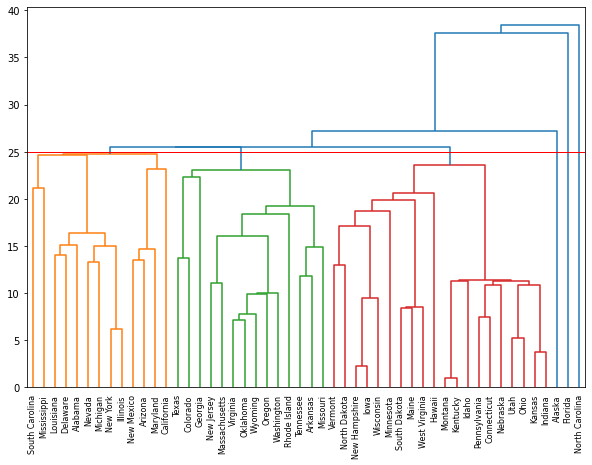

In [43]:
single = linkage(usarrests.iloc[:, 1::], metric='euclidean', method='single')
distance_threshold = 25 # 군집의 수를 설정하는 Height 값 설정

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram(single, orientation='top', labels=label_list, distance_sort='descending',
           color_threshold=distance_threshold, show_leaf_counts=True)

plt.axhline(y=distance_threshold, color='r', linewidth=1) # Height 값에 따라 선을 그어 줌
plt.show()

#### Ward Linkage Method
- 최소분산법
- 최단연결법의 단점 보완. 군집 내 오차(SSE)에 기반한 거리 측정
- 상대적으로 계산량이 많으나, 해석력이 높음

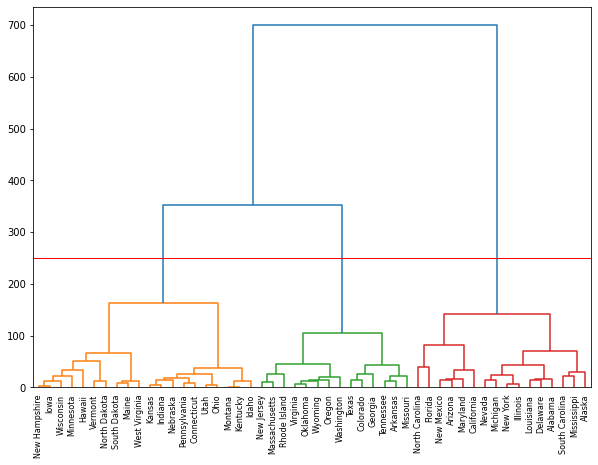

In [44]:
ward = linkage(usarrests.iloc[:, 1::], metric='euclidean', method='ward')
distance_threshold = 250 # 군집의 수를 설정하는 Height 값 설정

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram(ward, orientation='top', labels=label_list, distance_sort='descending',
           color_threshold=distance_threshold, show_leaf_counts=True)
plt.axhline(y=distance_threshold, color='r', linewidth=1) # Height 값에 따라 선을 그어 줌
plt.show()

In [45]:
# state마다 어떤 군집에 설정되었는지 확인
assignments = fcluster(ward, 250, 'distance')
assignments

array([1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 2, 1,
       3, 1, 2, 3, 3, 1, 3, 2, 1, 1, 1, 3, 3, 2, 2, 3, 2, 1, 3, 2, 2, 3,
       3, 2, 2, 3, 3, 2], dtype=int32)

In [46]:
usarrests['cluster'] = assignments
usarrests.groupby('cluster').mean()

,Murder,Assault,UrbanPop,Rape
cluster,,,,
1,11.812500,272.562500,68.312500,28.375000
2,8.214286,173.285714,70.642857,22.842857
3,4.270000,87.550000,59.750000,14.390000


In [47]:
### 특정 군집 개수에서의 군집 반환
n_cluster = 3
hcluster_result = cut_tree(ward, n_cluster).flatten()
hcluster_result

array([0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 1, 0,
       2, 0, 1, 2, 2, 0, 2, 1, 0, 0, 0, 2, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2,
       2, 1, 1, 2, 2, 1])

In [48]:
### 타당성 평가
print('Silhouette score:', silhouette_score(usarrests.iloc[:, 1::], hcluster_result))

Silhouette score: 0.534284923037737


#### Complete Linkage Method
- 최장연결법
- Scikit-learn 사용했으나, Scipy 사용도 위와 마찬가지로 가능

In [49]:
from sklearn.cluster import AgglomerativeClustering

In [50]:
### Agglomerative with Scikit-learn
x = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(x)

In [51]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [52]:
agg.labels_

array([1, 1, 0, 0])

In [53]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

#### Average Linkage Method & Gower distance

In [54]:
import gower

In [55]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
x

,dti,payment_inc_ratio,home_,purpose_
0,1.00,2.39320,RENT,major_purchase
1,5.55,4.57170,OWN,small_business
2,18.08,9.71600,RENT,other
3,10.08,12.21520,RENT,debt_consolidation
4,7.06,3.90888,RENT,other


In [56]:
dist_matrix = gower.gower_matrix(x)
model_average = AgglomerativeClustering(n_clusters=2, linkage='average', affinity='precomputed')
clusters_average = model_average.fit_predict(dist_matrix)
clusters_average

array([0, 1, 0, 0, 0])

### (2) HDBSCAN
- Hierachical DBSCAN
- 계층적 구조 및 Local density에 대한 정보 반영
- HDBDCAN Steps
    - Transform the space according to the density/sparsity.
    - Build the minimum spanning tree of the distance weighted graph.
    - Construct a cluster hierarchy of connected components.
    - Condense the cluster hierarchy based on minimum cluster size.
    - Extract the stable clusters from the condensed tree.

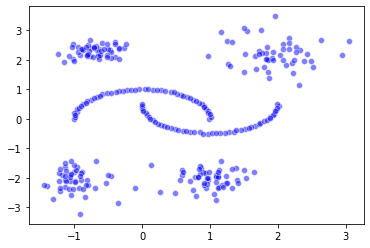

In [57]:
num = 100
moons, _ = make_moons(n_samples=num, noise=0.01)
blobs, _ = make_blobs(n_samples=num, centers=[(-0.75,2.25), (1.0, -2.0)], cluster_std=0.25)
blobs2, _ = make_blobs(n_samples=num, centers=[(2,2.25), (-1, -2.0)], cluster_std=0.4)
test_data = np.vstack([moons, blobs,blobs2])
sns.scatterplot(test_data.T[0], test_data.T[1], color='blue', alpha=0.5, linewidths=0)
plt.show()

In [58]:
# !pip install hdbscan
import hdbscan

In [59]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True) # min_size는 없을 경우 min_cluster_size로 자동 생성
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True)

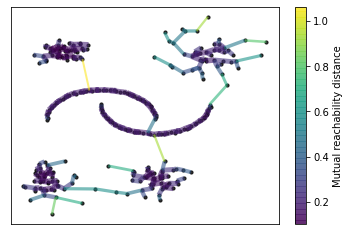

In [60]:
# Cluster hierachy tree 
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=10, edge_linewidth=2)
plt.show()

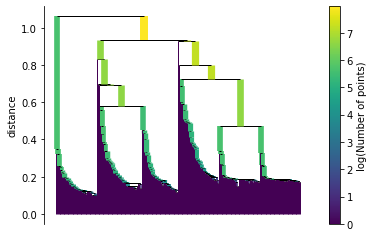

In [61]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True) # dendrogram
plt.show()

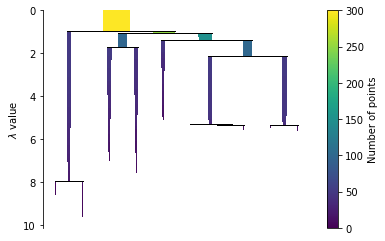

In [62]:
# 일정 distance 미만의 데이터(minimum size 미만의 클러스터)를 noise로 처리
clusterer.condensed_tree_.plot()
plt.show()

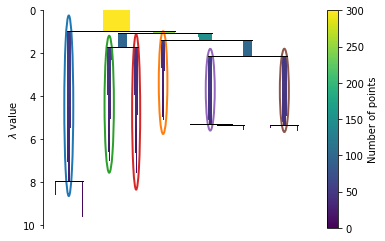

In [63]:
# 안정적인 클러스터 추출 (오래 살아남은 클러스터)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

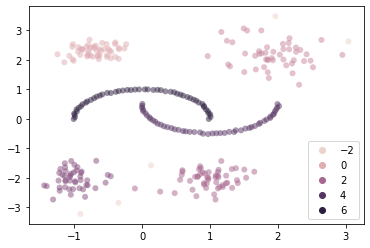

In [64]:
sns.scatterplot(x=test_data.T[0], y=test_data.T[1], hue=clusterer.labels_, linewidth=0, alpha=0.5)
plt.show()

## Non-hierarchical Clustering
- Partitional clustering
- 종류
    - Prototype-based: K-means, K-medoid, K-modes
    - Distribution-based: Mixture Distribution
    - Density-based: DBSCAN, OPTICS
    - Grid-based: STING, WaveCluster, CLIQUE (다루지는 않음)
    - ETC: SOM

### (1) K-Means
- 군집 개수만큼 초기값을 지정하고 초기 군집을 형성한 후, 평균을 재계산하여 값 갱신
- 이해와 구현이 쉽고, 비교적 빠른 알고리즘으로, 큰 데이터에서도 잘 작동함
- 초기 센트로이드는 K-means++ 알고리즘이 기본값 (random보다 좋음)
- Scaling 필요하며, 이상치 영향을 많이 받을 수 있음
- 클러스터 정의하는 것이 중심밖에 없고, 모든 클러스터의 반경이 같으며 모든 방향이 똑같이 중요하기 때문에 밀도가 다르거나 원형이 아닌 군집에 적합이 어려움
- 변수가 많은 경우 정확도가 떨어짐 (PCA 고려)
- Inertia
    - 각 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리
    - 랜덤 초기화를 하여 여러 번 알고리즘을 실행한 다음, 이너셔가 낮은 모델을 선택하게 됨
- 응용 분야: 변수 추가, Semi-supervised learning, 벡터 양자화 (하나의 성분: 군집으로 분해)

In [65]:
### wine data
wine_load = load_wine()
wine = pd.DataFrame(wine_load.data, columns=wine_load.feature_names)
wine['Class'] = wine_load.target
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [66]:
x = wine.drop('Class', axis=1)
y = wine['Class']

#### Best K

In [67]:
### Scaling
scaler = StandardScaler()
scaled = scaler.fit_transform(x)
scaled_df = pd.DataFrame(scaled, columns=[x.columns])

In [68]:
### Calinski harabasz
# 가장 높은 값 선택
for k in range(2, 10):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(scaled)
    print(f'calinski_harabasz for k={k}: {calinski_harabasz_score(scaled, kmeans_model.labels_)}')

calinski_harabasz for k=2: 69.48646422404195
calinski_harabasz for k=3: 70.9400080031512
calinski_harabasz for k=4: 55.500838344431685
calinski_harabasz for k=5: 46.4992732182332
calinski_harabasz for k=6: 41.177277945279265
calinski_harabasz for k=7: 37.38079720850211
calinski_harabasz for k=8: 35.10840443686213
calinski_harabasz for k=9: 34.18136656545545


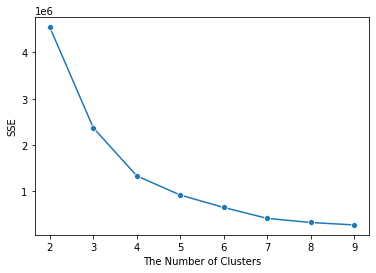

[4543749.614531863, 2370689.6867829696, 1331903.0622637179, 916379.1871539167, 648422.2834974247, 412303.82825080125, 323211.55263465457, 270954.92924153735]


In [69]:
### elbow plot
# SSE(inertia)가 급격하게 줄거나, 기울기가 소실되는 구간 판단
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(x) for k in range(2, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

sns.lineplot(range(2, 10), inertias, marker='o')
plt.xlabel('The Number of Clusters')
plt.ylabel('SSE')
plt.show()

print(inertias)

In [70]:
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

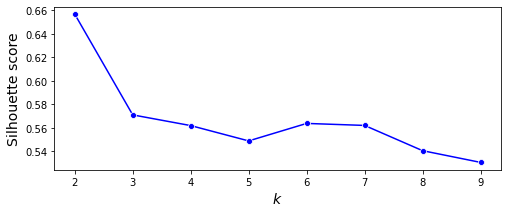

In [71]:
### Silhouette score
# 샘플 개수 실루엣 계수 종합적으로 판단
# 전체 평균이 1에 가까울수록 좋음
# 군집의 스코어 편차가 작은 것이 좋음
silhouette_scores = [silhouette_score(x, model.labels_) for model in kmeans_per_k]

plt.figure(figsize=(8, 3))
sns.lineplot(range(2, 10), silhouette_scores, color='blue', marker="o")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

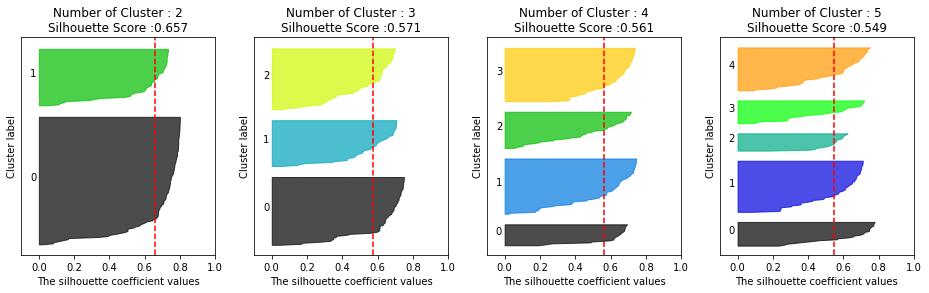

In [72]:
### Silhouette diagram
# 클러스터링 개수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
cluster_lists = [2, 3, 4, 5]
n_cols = len(cluster_lists)
fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

# 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
for ind, n_cluster in enumerate(cluster_lists):
    # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
    clusterer = KMeans(n_clusters=n_cluster, random_state=0)
    cluster_labels = clusterer.fit_predict(x)
        
    sil_avg = silhouette_score(x, cluster_labels)
    sil_values = silhouette_samples(x, cluster_labels)
        
    y_lower = 10
    axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\nSilhouette Score :' + str(round(sil_avg,3)))
    axs[ind].set_xlabel("The silhouette coefficient values")
    axs[ind].set_ylabel("Cluster label")
    axs[ind].set_xlim([-0.1, 1])
    axs[ind].set_ylim([0, len(x) + (n_cluster + 1) * 10])
    axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
    axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
    # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
    for i in range(n_cluster):
        ith_cluster_sil_values = sil_values[cluster_labels==i]
        ith_cluster_sil_values.sort()
            
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
            
        color = cm.nipy_spectral(float(i) / n_cluster)
        axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
        axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
            
    axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

#### Basic K-means

In [73]:
# 최적의 k로  K-Means 군집화 실행
km = KMeans(n_clusters=3, random_state=1)
km.fit(x)

KMeans(n_clusters=3, random_state=1)

In [74]:
# inertia
km.inertia_

2370689.6867829696

In [75]:
# score는 음수 출력 (클 수록 좋은 것 규칙)
km.score(x)

-2370689.6867829696

In [76]:
# labels
km.labels_

array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 0, 0, 2,
       0, 0, 2, 2, 2, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2,
       2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0], dtype=int32)

In [77]:
# 할당된 군집을 데이터에 추가
new_labels = km.labels_
wine['cluster'] = new_labels
wine.groupby(['cluster']).mean()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class
cluster,,,,,,,,,,,,,,
0,12.516667,2.494203,2.288551,20.823188,92.347826,2.070725,1.758406,0.390145,1.451884,4.086957,0.941159,2.490725,458.231884,1.275362
1,13.804468,1.883404,2.426170,17.023404,105.510638,2.867234,3.014255,0.285319,1.910426,5.702553,1.078298,3.114043,1195.148936,0.021277
2,12.929839,2.504032,2.408065,19.890323,103.596774,2.111129,1.584032,0.388387,1.503387,5.650323,0.883968,2.365484,728.338710,1.258065


In [78]:
### class와 cluster 비교
# label은 알고리즘이 결정하므로 달라질 수 잇음
wine.groupby('Class')['cluster'].value_counts()

Class  cluster
0      1          46
       2          13
1      0          50
       2          20
       1           1
2      2          29
       0          19
Name: cluster, dtype: int64

In [79]:
confusion_matrix(y, wine['cluster'])

array([[ 0, 46, 13],
       [50,  1, 20],
       [19,  0, 29]])

In [80]:
### 타당성 평가
print('Silhouette score:', silhouette_score(x, wine['cluster']))
print('Completeness score:', completeness_score(y, wine['cluster']))

Silhouette score: 0.5711381937868838
Completeness score: 0.42870141389448585


In [81]:
### centroids
centroids = km.cluster_centers_
centroids

array([[1.25166667e+01, 2.49420290e+00, 2.28855072e+00, 2.08231884e+01,
        9.23478261e+01, 2.07072464e+00, 1.75840580e+00, 3.90144928e-01,
        1.45188406e+00, 4.08695651e+00, 9.41159420e-01, 2.49072464e+00,
        4.58231884e+02],
       [1.38044681e+01, 1.88340426e+00, 2.42617021e+00, 1.70234043e+01,
        1.05510638e+02, 2.86723404e+00, 3.01425532e+00, 2.85319149e-01,
        1.91042553e+00, 5.70255319e+00, 1.07829787e+00, 3.11404255e+00,
        1.19514894e+03],
       [1.29298387e+01, 2.50403226e+00, 2.40806452e+00, 1.98903226e+01,
        1.03596774e+02, 2.11112903e+00, 1.58403226e+00, 3.88387097e-01,
        1.50338710e+00, 5.65032258e+00, 8.83967742e-01, 2.36548387e+00,
        7.28338710e+02]])

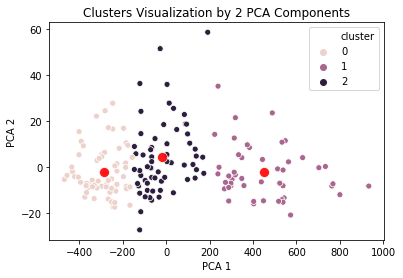

In [82]:
### PCA로 2차원 시각화
x = wine.drop(['Class', 'cluster'], axis=1)

try:
    x = x.drop(['pca_x', 'pca_y'], axis=1)
except KeyError:
    pass

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(x)
centroids_transformed = pca.transform(centroids)

wine['pca_x'] = pca_transformed[:, 0]
wine['pca_y'] = pca_transformed[:, 1]

sns.scatterplot(x=wine['pca_x'], y=wine['pca_y'], hue=wine.cluster)
sns.scatterplot(x=centroids_transformed[:, 0], y=centroids_transformed[:, 1], s=100, linewidths=8, color='red', alpha=0.9)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters Visualization by 2 PCA Components')
plt.show()

In [83]:
### new data predict
x_new = np.array([[14, 1.7, 2.7, 14.8, 110.0, 2.80, 2.16, 0.4, 2.5, 6.0, 1.04, 3.92, 1020.0], [19.7, 4.5, 2.3, 21.0, 120.0, 1.6, 0.82, 0.4, 1.2, 10.1, 0.60, 1.8, 840.0]])
km.predict(x_new)

array([1, 2], dtype=int32)

In [84]:
### n_init 지정 (default 10)
kmeans_rnd_10_inits = KMeans(n_clusters=3, n_init=5, init="random", algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(x)

KMeans(algorithm='full', init='random', n_clusters=3, n_init=5, random_state=2)

In [85]:
### elkan 알고리즘은 더 빠르지만, 희소 행렬은 지원하지 않음
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(x)

13.3 ms ± 477 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [86]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(x)

18.5 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [87]:
from sklearn.metrics import pairwise_distances_argmin_min

In [88]:
### Cohesion, Separation
# Cohesion(응집도): 클러스터 내의 모든 거리 가중치의 합. 클러스터 내의 객체들이 밀집해있는 정도를 측정함(=SSE, inertia)
# Separation(분리도): 클러스터 외부 객체 간의 모든 거리 가중치의 합으로, 클러스터 간 잘 분리되어 있는 정도를 측정함. 각 클러스터의 중심점과의 pairwise 거리 최소값으로 측정
d = pairwise_distances_argmin_min(km.cluster_centers_, scaled_df)[1]

print(f'K-means 군집결과의 응집도는 {round(km.inertia_, 3)}, 분리도는 {round(sum(d) / len(d), 3)}')

K-means 군집결과의 응집도는 2370689.687, 분리도는 798.381


#### Minibatch K-means

In [89]:
from sklearn.cluster import MiniBatchKMeans

In [90]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(x)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [91]:
minibatch_kmeans.inertia_

940729.7475238508

In [92]:
### partial fit
# batch load
def load_next_batch(batch_size):
    return np.array(x)[np.random.choice(len(np.array(x)), batch_size, replace=False)]

k = 5
n_init = 10
n_iterations = 100
batch_size = 20
init_size = 50  # K-Means++ 초기화를 위해 충분한 데이터 전달
evaluate_on_last_n_iters = 10

best_kmeans = None
np.random.seed(42)
for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    x_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(x_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        x_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(x_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans
        
best_kmeans.score(x)

-920589.4968601471

In [93]:
from timeit import timeit

In [94]:
# 시간 비교
times = np.empty((20, 2))
inertias = np.empty((20, 2))
for k in range(1, 21):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 20), end="")
    times[k-1, 0] = timeit("kmeans_.fit(x)", number=3, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(x)", number=3, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

20/20

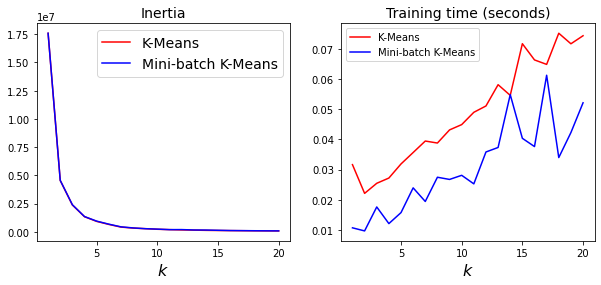

In [95]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.lineplot(x=range(1, 21), y=inertias[:, 0], color="red", linestyle="dashed", label="K-Means")
sns.lineplot(x=range(1, 21), y=inertias[:, 1], color="blue", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(122)
sns.lineplot(x=range(1, 21), y=times[:, 0], color="red", linestyle="dashed", label="K-Means")
sns.lineplot(x=range(1, 21), y=times[:, 1], color="blue", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.show()

### (2) K-medoids
- 평균 대신 중앙값 사용
- K-means보다 계산량은 다소 많으나 변수 scale과 이상치에 덜 민감함

In [96]:
x = wine.drop(['Class', 'cluster'], axis=1)

In [97]:
# !pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

In [98]:
kme = KMedoids(n_clusters=3, metric='euclidean', random_state=1)
kme.fit(x)

# 할당된 군집을 데이터에 추가
new_labels = kme.labels_
wine['cluster_kme'] = new_labels

In [99]:
confusion_matrix(wine['cluster'], wine['cluster_kme']) # 군집이 조금 다르게 이루어졌음

array([[66,  3,  0],
       [ 0,  0, 47],
       [ 0, 59,  3]])

### (3) K-modes
- 평균 대신 최빈값 사용
- 범주형 데이터에 적용할 수 있음 

In [100]:
df = pd.DataFrame({'취미': ['게임', '영화', '요리', '등산', '영화', '등산', '요리', '등산'],
                   '과목':['수학', '국어', '영어', '과학', '수학', '국어', '영어', '과학'],
                   '성별': ['남자', '여자', '여자', '여자', '남자', '여자', '남자', '남자']})

In [101]:
from sklearn.preprocessing import LabelEncoder

In [102]:
encoder = LabelEncoder()
for col in df.columns:
    df[col] = encoder.fit_transform(df[col])
df

,취미,과목,성별
0,0,2,0
1,2,1,1
2,3,3,1
3,1,0,1
4,2,2,0
5,1,1,1
6,3,3,0
7,1,0,0


In [103]:
# !pip install kmodes
from kmodes.kmodes import KModes

In [104]:
kmodes = KModes(n_clusters=3, init=df.iloc[[0, 6, 7], :]) ## 클래스 초기화
kmodes.fit(df) ## 클러스터링 수행

new_labels = kmodes.labels_
new_labels

array([0, 0, 1, 2, 0, 2, 1, 2], dtype=uint16)

### (4) Mean Shift
- 중심을 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동시킴
- 데이터의 분포를 이용하여 군집 중심을 찾음
- KDE (Kernel Density Estimation) 이용
    - 적절한 KDE bandwidth(h) 제공이 중요
    - 작을수록 좁고 뾰족한 KDE이며, overfitting 확률이 높음

In [105]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [106]:
x, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift= MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(x)
print('cluster labels 유형:', np.unique(cluster_labels))

meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(x)
print('cluster labels 유형:', np.unique(cluster_labels))

bandwidth = estimate_bandwidth(x)
print('bandwidth 값:', round(bandwidth,3))

cluster labels 유형: [ 0  1  2  3  4  5  6  7  8  9 10]
cluster labels 유형: [0 1 2 3]
bandwidth 값: 1.754


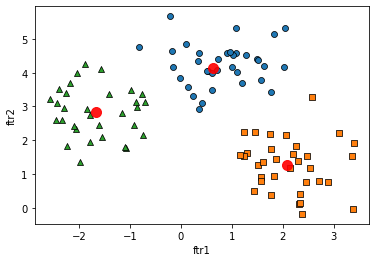

In [107]:
cluster = pd.DataFrame(data=x, columns=['ftr1', 'ftr2'])
cluster['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(x)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster['meanshift_label']  = meanshift.fit_predict(x)
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster['meanshift_label'])
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = cluster[cluster['meanshift_label']==label]
    center_x_y = centers[label]
    
    # 군집별로 다른 마커로 산점도 적용
    sns.scatterplot(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])
    
    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=100, color='red', alpha=0.9)
    
plt.show()

In [108]:
print(cluster.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  33
        1                   1
1       1                  33
2       2                  31
        0                   2
Name: meanshift_label, dtype: int64


### (5) Mixture distribution
- 분포 기반 군집분석. 어느 모형(분포)에서 나왔을 확률이 높은지를 계산하며, 통계적으로 엄밀한 결과를 얻을 수 있음
- 클러스터들은 각자 서로 다른 확률분포에서 발생한 것으로 가정하며, 클러스터를 몇 개의 모수로 표현 가능함
- 일반적으로 타원형 클러스터를 가정하며, KMeans가 잘 구분하지 못하는 길게 늘어난 타원형의 데이터 셋도 잘 적합됨
- 반달 모양에는 잘 적합되지 않음 -> DBSCAN 사용
- 주로 정규분포를 가정하나, 다른 분포여도 상관없음
- 군집의 크기가 너무 작거나, 가정한 분포와 실제 데이터의 차이가 크면 성능이 떨어짐
- 필요한 계산량이 높아 대용량 데이터에는 적용이 어려움
- 이상치 처리, scaling 필요
- EM(Expectation-Maximization) Algorithm
    - 초기값 설정
    - 잠재변수 Z의 기대치 계산 (X가 특정 군집에 속할 확률)
    - 기대치를 이용해 파라미터 추정 (계산된 확률로 모수 추정)
    - 반복 정지. Likelihood가 최대가 될 때 수렴함
- Covariance types
    - full(기본값): 제약 없음. 모든 클러스터가 어떤 크기의 타원도 될 수 있음
    - tied: 모든 클러스터가 동일하지만 타원 mix 가능(=공분산 행렬 공유)
    - spherical: 모든 클러스터가 원형이지만 지름은 다를 수 있음(=분산이 다름)
    - diag: 클러스터는 어떤 크기의 타원도 될 수 있지만 타원은 축에 나란해야 함(=공분산 행렬이 대각 행렬)

In [109]:
from sklearn.mixture import GaussianMixture

In [110]:
gmm = GaussianMixture(n_components=3, covariance_type="full")
gmm.fit(scaled_feature) ### scaled iris data

iris['gmm_cluster'] = gmm.predict(scaled_feature)

In [111]:
### 각 component(class)의 가중치
gmm.weights_

array([0.30131887, 0.33333333, 0.36534779])

In [112]:
### 각 군집의 mean
gmm.means_

array([[ 0.08941479, -0.64289312,  0.25434691,  0.13056099],
       [-1.01457897,  0.85326268, -1.30498732, -1.25489349],
       [ 0.85192968, -0.24827046,  0.98086333,  1.03725094]])

In [113]:
### 각 군집의 covariance
gmm.covariances_

array([[[0.40451295, 0.2694864 , 0.12774707, 0.08740359],
        [0.2694864 , 0.49041904, 0.11910438, 0.13029284],
        [0.12774707, 0.11910438, 0.06538755, 0.04618656],
        [0.08740359, 0.13029284, 0.04618656, 0.05604601]],

       [[0.17877068, 0.27120389, 0.01103828, 0.01614737],
        [0.27120389, 0.74619275, 0.01499926, 0.02761055],
        [0.01103828, 0.01499926, 0.00954905, 0.00445008],
        [0.01614737, 0.02761055, 0.00445008, 0.01885974]],

       [[0.56884756, 0.2572629 , 0.20828688, 0.09706782],
        [0.2572629 , 0.58506957, 0.10969738, 0.1688923 ],
        [0.20828688, 0.10969738, 0.1052695 , 0.05441482],
        [0.09706782, 0.1688923 , 0.05441482, 0.1469758 ]]])

In [114]:
# EM 수렴 여부
gmm.converged_

True

In [115]:
### 반복 횟수
gmm.n_iter_

21

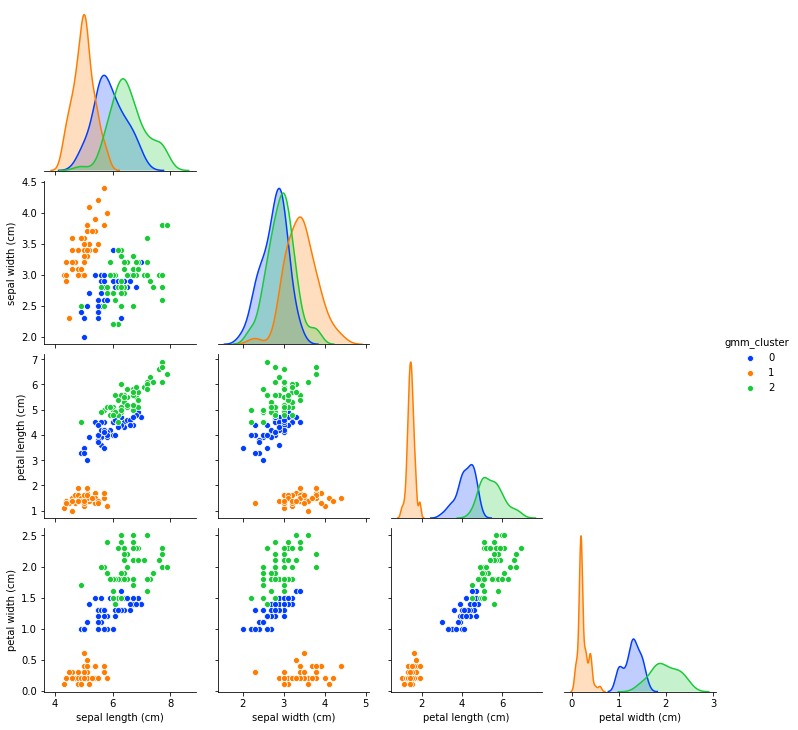

In [116]:
### 군집결과 시각화
sns.pairplot(iris.drop(['Class'], axis=1), diag_kind='kde', hue="gmm_cluster", corner=True, palette='bright')
plt.show()

In [117]:
# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인. 
iris_result = iris.groupby(['Class'])['gmm_cluster'].value_counts()
print(iris_result)

Class  gmm_cluster
0      1              50
1      0              45
       2               5
2      2              50
Name: gmm_cluster, dtype: int64


In [118]:
### 타당성 평가
print('Silhouette score:', silhouette_score(scaled_feature, iris['gmm_cluster']))
print('Completeness score:', completeness_score(iris['Class'], iris['gmm_cluster']))

Silhouette score: 0.3741649186654123
Completeness score: 0.9010648908640206


In [119]:
### predict
gmm.predict(np.array([[1, 2, 1, 2], [3, 3, 3, 3]]))
# gmm.predict_proba() -> 확률 값 제시

array([2, 2])

In [120]:
### 군집으로부터 샘플 생성 가능 -> 분포를 가정하고 있는 생성 모델의 특징
x_new, y_new = gmm.sample(6)
print(x_new, y_new)

[[-0.49781434 -0.70847467  0.19235815  0.14376317]
 [ 1.34389284  0.31591807  1.08089831  0.57245773]
 [-1.0132576   1.71914288 -1.35439256 -1.37358072]
 [-0.85331758  0.73150424 -1.31689459 -1.5377382 ]
 [ 1.2652274  -0.69314097  1.09127682  1.31833044]
 [ 1.60003154  0.39963047  1.32218641  1.25180119]] [0 0 1 1 2 2]


In [121]:
### log-likelihood 계산
# 점수가 높을수록 밀도가 높음
gmm.score_samples(x_new)

array([-0.60438962, -3.40548877, -0.53737532, -1.77179992, -2.46610048,
       -1.69068688])

#### Best K
- BIC, AIC 등 이론적 정보 기준 사용
- 과한 클러스터를 제한하고, 데이터의 잘 맞는 모델을 찾음

In [122]:
gmm.bic(scaled_feature)

801.5535017494138

In [123]:
gmm.aic(scaled_feature)

669.0855488091786

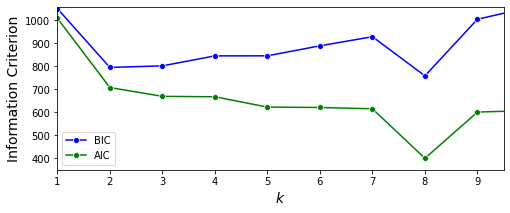

In [124]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(scaled_feature) for k in range(1, 11)]

bics = [model.bic(scaled_feature) for model in gms_per_k]
aics = [model.aic(scaled_feature) for model in gms_per_k]

plt.figure(figsize=(8, 3))
sns.lineplot(range(1, 11), bics, color='blue', marker='o', label="BIC")
sns.lineplot(range(1, 11), aics, color='green', marker='o', linestyle='dashed', label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.legend()
plt.show()

In [125]:
### Best K and covariance type
min_bic = np.infty
for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10, covariance_type=covariance_type, random_state=42).fit(scaled_feature).bic(scaled_feature)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [126]:
print(best_k, best_covariance_type)

8 full


In [127]:
### Outlier detection with Gaussian Mixture
# 밀도가 낮은 지역에 있는 샘플을 이상치로 생각할 수 있음
# 사용할 밀도 임곗값을 결정해야 함
densities = gmm.score_samples(scaled_feature)
density_threshold = np.percentile(densities, 1) # 밀도 임계값 정의

anomalies = scaled_feature[densities < density_threshold]
anomalies

array([[ 2.24968346, -1.05276654,  1.78583195,  1.44883158],
       [ 2.4920192 ,  1.70959465,  1.50164482,  1.05393502]])

#### Bayesian Gaussian Mixture
- 불필요한 클러스터의 가중치를 0으로 (또는 0에 가깝게) 수렴시킴
- 최적의 클러스터 개수보다 큰 컴포넌트의 개수 지정
- 클러스터 파라미터(가중치, 평균, 공분산 행렬)는 잠재 변수
    - 평균은 베타 분포, 공분산 행렬은 위샤트 분포로 추론
- weight_concentration_prior (default=1/n_components)
    - 클러스터 개수에 대한 사전 믿음으로, n_components에 설정된 군집수에 대한 규제로 사용됨
    - 작은 값이면 특정 군집의 가중치를 0에 가깝게 만들어 군집수를 줄이도록 함
    - 즉, 큰 값일 수록 n_components에 설정된 군집수가 유지되도록 함

In [128]:
from sklearn.mixture import BayesianGaussianMixture

In [129]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(scaled_feature)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

In [130]:
np.round(bgm.weights_, 2) # 3개의 클러스터 감지

array([0.31, 0.33, 0.35, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

### (6) DBSCAN
- Density Based Spatial Clusting of Applications with Noise
- 초기 군집 개수를 정해주지 않아도 됨 (eps 값으로 간접적으로 결정함)
- 주변 epsilon 거리의 데이터를 군집으로 인식하고, 최소 군집 데이터 수를 정할 수 있음
    - epsilon-이웃
    - epsilon-이웃 안에 min_samples 이상의 샘플이 있다면, core instance
    - core instance의 이웃은 동일한 클러스터 (밀집 지역의 샘플)
    - 클러스터에 들어가지 못하면 이상치로 판단 (-1)
- 반달 형태 등 비선형 군집에 잘 적합하며, 노이즈를 판단할 수 있다는 장점이 있음
- 단, 밀도가 낮은 곳의 데이터를 군집으로 인식하지 못할 수도 있음
- K-means보다 다소 느리고, 데이터가 많으면 모델링 시간이 증가함
- 새로운 데이터의 군집 예측 불가 (예측이 필요하면 KNN Classifier 사용)

In [131]:
from sklearn.cluster import DBSCAN

In [132]:
dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean') # metric default는 euclidean

In [133]:
predict = pd.DataFrame(dbscan.fit_predict(scaled_feature))
predict.columns=['predict']

r = pd.concat([pd.DataFrame(scaled_feature, columns=iris.columns[:4]), predict],axis=1)
r['target'] = iris.Class
r.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),predict,target
0,-0.900681,1.019004,-1.340227,-1.315444,0,0
1,-1.143017,-0.131979,-1.340227,-1.315444,0,0
2,-1.385353,0.328414,-1.397064,-1.315444,0,0
3,-1.506521,0.098217,-1.283389,-1.315444,0,0
4,-1.021849,1.249201,-1.340227,-1.315444,0,0


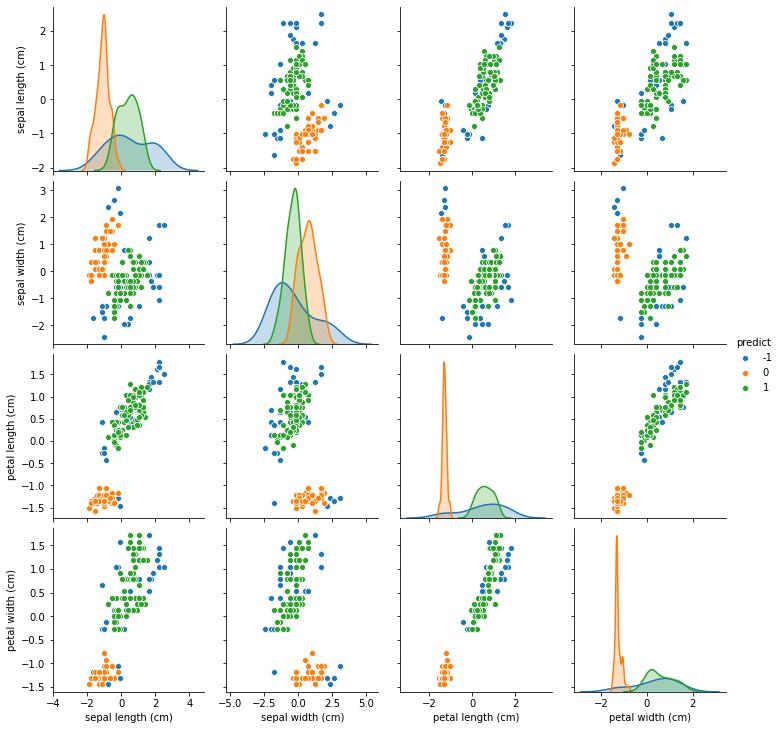

In [134]:
sns.pairplot(r.drop('target', axis=1), hue='predict')
plt.show()

In [135]:
iris_result = r.groupby(['target'])['predict'].value_counts()
iris_result

target  predict
0        0         45
        -1          5
1        1         40
        -1         10
2        1         33
        -1         17
Name: predict, dtype: int64

In [136]:
dbscan.labels_[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [137]:
dbscan.core_sample_indices_[:10] # 핵심 샘플 index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10])

In [138]:
dbscan.components_[:3] # 핵심 샘플

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ]])

In [139]:
np.unique(dbscan.labels_) # -1은 이상치

array([-1,  0,  1])

In [140]:
### 타당성 평가
print('Silhouette score:', silhouette_score(feature, r['predict']))
print('Completeness score:', completeness_score(r['target'], r['predict']))

Silhouette score: 0.3914993916101798
Completeness score: 0.5305282174212304


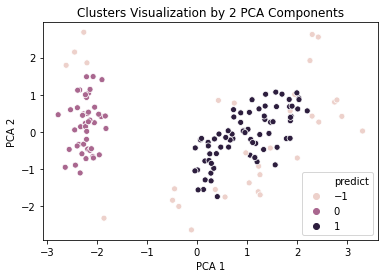

In [141]:
# 2차원으로 시각화
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(scaled_feature)

sns.scatterplot(x=pca_transformed[:, 0], y=pca_transformed[:, 1], hue=r.predict)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters Visualization by 2 PCA Components')
plt.show()

target  predict
0        0         48
        -1          2
1        1         49
        -1          1
2        1         45
        -1          5
Name: predict, dtype: int64


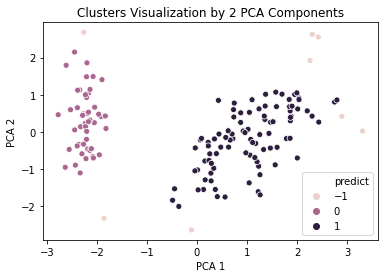

In [142]:
### eps 0.8로 상승 -> noise 감소
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(scaled_feature)

r['predict'] = dbscan_labels
r['target'] = iris.Class

iris_result = r.groupby(['target'])['predict'].value_counts()
print(iris_result)

# 2차원으로 시각화
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(scaled_feature)

sns.scatterplot(x=pca_transformed[:, 0], y=pca_transformed[:, 1], hue=r.predict)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters Visualization by 2 PCA Components')
plt.show()

target  predict
0        0         41
        -1          9
1       -1         28
         1         22
2       -1         45
         1          5
Name: predict, dtype: int64


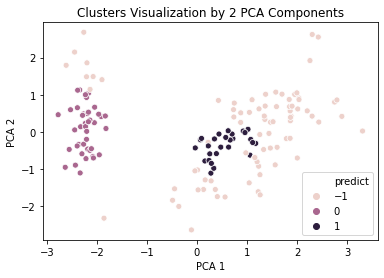

In [143]:
### min_samples 상승 -> noise 증가
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(scaled_feature)

r['predict'] = dbscan_labels
r['target'] = iris.Class

iris_result = r.groupby(['target'])['predict'].value_counts()
print(iris_result)

# 2차원으로 시각화
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(scaled_feature)

sns.scatterplot(x=pca_transformed[:, 0], y=pca_transformed[:, 1], hue=r.predict)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters Visualization by 2 PCA Components')
plt.show()

In [144]:
from sklearn.neighbors import KNeighborsClassifier

In [145]:
### KNN을 이용한 새 데이터 예측 구현
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=20)

In [146]:
x_new = np.array([[-0.5, 0, 0, 1], [0, 0.5, 0, 5]])
knn.predict(x_new)
# knn.predict_proba(x_new)

array([0, 0])

In [147]:
y_dist, y_pred_idx = knn.kneighbors(x_new, n_neighbors=1) # x_new의 이웃 정보
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]

y_pred[y_dist > 0.2] = -1 # 일정 거리 이상인 경우 outlier 처리
y_pred.ravel()

array([-1, -1])

In [148]:
### Gower distance 사용
# 범주형 변수가 있는 경우
'''
import gower

distance_matrix = gower.gower_matrix(dataframe)
columns = [f'Customer_{i}' for i in range(1,11)]
distance_matrix = pd.DataFrame(distance_matrix, index=columns, columns=columns)

dbscan_cluster = DBSCAN(eps=0.3, min_samples=2, metric="precomputed")
dbscan_cluster.fit(distance_matrix)

dbscan_cluster.labels_
'''

'\nimport gower\n\ndistance_matrix = gower.gower_matrix(dataframe)\ncolumns = [f\'Customer_{i}\' for i in range(1,11)]\ndistance_matrix = pd.DataFrame(distance_matrix, index=columns, columns=columns)\n\ndbscan_cluster = DBSCAN(eps=0.3, min_samples=2, metric="precomputed")\ndbscan_cluster.fit(distance_matrix)\n\ndbscan_cluster.labels_\n'

### (7) OPTICS
- Ordering Points To Identify the Clustering Structure
- DBSCAN의 확장 버전으로, 다양한 밀도를 가진 데이터에서 클러스터를 잘 찾아내지 못하는 문제를 해결하기 위해 고안
- 데이터들을 정렬하여 가까운 point들이 이웃이 될 수 있도록 하며, 각 point가 더 밀집된 cluster에 포함될 수 있도록 함
- 실제로 클러스터를 생성하지는 않고, 밀도 기반 클러스터링 구조를 표현하는 인자를 순서화
- 동작 방식
    - 임의의 object o 선택
    - object o로부터 나머지 object까지의 reachability distance를 계산하고 가장 작은 value를 가진 object 선택
    - 새로 선택된 object에 대해 다른 object까지의 reachability distance를 계산하고 위와 비교해서 더 작은 값을 object에 대한 value로 사용
    - 가장 작은 value를 가진 object를 선택하고 이 과정을 반복
    - 맨 처음 선택된 object에 대해서는 infinity 배정
- core distance: 특정 데이터를 core point로 만들어주는 최소 distance
- reachability distance: 거리가 core point와 충분히 가까운(eps) 특정 데이터의 core point와의 최소 distance (directly density-rechable) 
- clustering methods
    - 계산된 reachability와 ordering으로부터 클러스터를 정하는 방법
    - DBSCAN-like(cluster_method='dbscan'), Xi(cluster_method=‘xi’)
- xi: reachability plot의 최소 경사도. 0~1 사이의 값을 가지며, default는 0.05. cluster_method가 xi일때만 사용됨
- eps: 두 데이터ㅡㄹ 이웃으로 판단하는 거리 기준. cluster_method가 dbscan일때만 사용됨

In [149]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan, cluster_optics_xi

In [150]:
optics_xi = OPTICS(min_samples=15, xi=0.15, min_cluster_size=0.05, metric='minkowski') # metric default는 p=2인 minkowski (euclidean). p값도 파라미터로 지정 가능

pred = optics_xi.fit_predict(scaled_feature) # model fit 이후에 optics_xi.labels_ 실행한 결과와 동일
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [151]:
### 타당성 평가
print('Silhouette score:', silhouette_score(scaled_feature, pred))
print('Completeness score:', completeness_score(iris['Class'], pred))

Silhouette score: 0.5817500491982808
Completeness score: 0.9999999999999997


In [152]:
np.unique(optics_xi.labels_) # -1은 이상치

array([0, 1])

In [153]:
optics_xi.ordering_ # 알고리즘에 의해 선택된 순서

array([  0,   4,   7,  11,  17,  20,  21,  26,  27,  28,  31,  37,  39,
        23,  24,  40,  49,  43,   2,  29,  34,  35,   9,   6,  36,   3,
        12,  30,  42,  45,  47,  10,  48,   1,  19,  22,  46,  38,   8,
        13,  25,   5,  16,  18,  44,  32,  14,  33,  15,  41,  98,  53,
        57,  62,  68,  69,  55,  63,  66,  67,  71,  73,  78,  61,  91,
        96,  97,  99, 126, 127, 133, 138,  74,  82,  88,  90,  92,  94,
        95,  64, 149,  83,  54,  84,  58, 103, 111, 123, 134,  51,  75,
        76, 101, 128, 142,  77, 104, 116, 132, 137, 147, 110, 112, 115,
       139, 140, 145,  52,  65,  86, 141, 102, 120, 143,  59, 124, 125,
        79,  89,  70,  72, 100, 136, 144, 148,  56, 146, 121,  50,  80,
        81, 108,  85, 129, 105, 107, 130, 135, 113,  93, 114, 106,  87,
       119, 109, 122,  60, 118, 117, 131])

In [154]:
optics_xi.core_distances_[optics_xi.ordering_][:20]

array([0.50760619, 0.53534506, 0.49719351, 0.53255121, 0.482203  ,
       0.69988351, 0.59751071, 0.51493247, 0.52027763, 0.52027763,
       0.72069915, 0.58585616, 0.47945214, 0.62889516, 0.58561217,
       0.50684599, 0.49393409, 0.64654784, 0.52337301, 0.50684599])

In [155]:
optics_xi.reachability_[optics_xi.ordering_][:20]

array([       inf, 0.50760619, 0.50760619, 0.49719351, 0.49719351,
       0.482203  , 0.482203  , 0.482203  , 0.482203  , 0.482203  ,
       0.482203  , 0.482203  , 0.482203  , 0.47945214, 0.47945214,
       0.47945214, 0.47945214, 0.482203  , 0.49393409, 0.49393409])

In [156]:
optics_xi.labels_[optics_xi.ordering_]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [157]:
cluster_optics_xi(reachability=optics_xi.reachability_, ordering=optics_xi.ordering_, predecessor=optics_xi.predecessor_, min_samples=15, xi=0.15)[0] # 위 결과와 동일

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

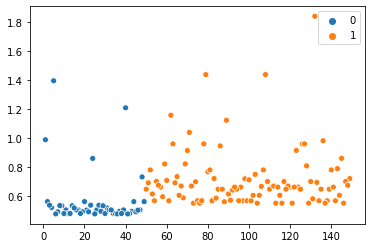

In [158]:
# reachability distance 시각화
sns.scatterplot(x=optics_xi.ordering_, y=optics_xi.reachability_, hue=optics_xi.labels_)
plt.show()

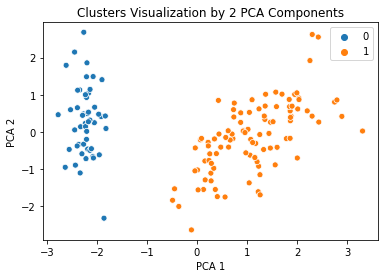

In [159]:
# 2차원으로 시각화
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(scaled_feature)

sns.scatterplot(x=pca_transformed[:, 0], y=pca_transformed[:, 1], hue=pred)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters Visualization by 2 PCA Components')
plt.show()

In [160]:
optics_dbscan = OPTICS(min_samples=15, eps=1.0, min_cluster_size=0.05, metric='minkowski', cluster_method='dbscan') # dbscan method

pred = optics_dbscan.fit_predict(scaled_feature) # = optics_dbscan.labels_ 
pred

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [161]:
### 타당성 평가
print('Silhouette score:', silhouette_score(scaled_feature, pred))
print('Completeness score:', completeness_score(iris['Class'], pred))

Silhouette score: 0.5265913018074803
Completeness score: 0.7645702789261025


In [162]:
cluster_optics_dbscan(reachability=optics_dbscan.reachability_, core_distances=optics_dbscan.core_distances_, ordering=optics_dbscan.ordering_, eps=1.0) # 위 결과와 동일

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

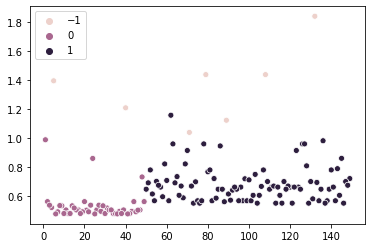

In [163]:
# reachability distance 시각화
sns.scatterplot(x=optics_dbscan.ordering_, y=optics_dbscan.reachability_, hue=optics_dbscan.labels_)
plt.show()

### (8) SOM
- Self-Organizing Maps (Kohonen Map)
- unsupervised NN
- 완전 연결된 두 개의 layer 구성 (input layer - competitive layer)
    - 뉴런의 개수는 입력 데이터의 개수와 군집 수가 됨
    - Feed=forward flow 학습 진행
- 각 뉴런에서 거리를 구해, 승자 독점 학습 (경쟁 학습)
- 가까운 거리의 뉴런은 비슷한 input, 멀리 떨어진 뉴런은 다른 input을 표현
- 입력 데이터 사이의 위상을 잘 나타내며, 잘 구별되지 않는 데이터 간의 상관관계를 찾아낼 수 있음
- 선택하는 거리 지표에 따라 결과 차이가 크고, 연산이 복잡하여 큰 데이터에는 적용하기 어려움

In [164]:
### wine data
wine.reset_index(inplace=True, drop=True)
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class,cluster,pca_x,pca_y,cluster_kme
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,1,318.562979,21.492131,2
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,1,303.097420,-5.364718,2
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,1,438.061133,-6.537309,2
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,1,733.240139,0.192729,2
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,2,-11.571428,18.489995,1


In [165]:
som_data = wine.drop(['Class', 'cluster'], axis=1)
som_target = wine['Class']

# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
som_array = sc.fit_transform(som_data)

#### sklearn_som

In [166]:
# !pip install sklearn-som
from sklearn_som.som import SOM

In [167]:
### best size 결정하기
mn_list = [(2, 1), (3, 1), (2, 2), (5, 1)]
for (m, n) in mn_list:
    som = SOM(m=m, n=n, dim=som_data.shape[1])
    som.fit(som_array)
    labels = som.predict(som_array)
    score = silhouette_score(som_data, labels)
    print(f'Silhouette score of ({m}, {n}): {score}')

Silhouette score of (2, 1): 0.5210855205138384
Silhouette score of (3, 1): 0.2366986080361141
Silhouette score of (2, 2): 0.012756176371067338
Silhouette score of (5, 1): 0.150726558280946


In [168]:
n_neurons = 1
m_neurons = 3

som = SOM(m=m_neurons, n=n_neurons, dim=som_array.shape[1])
som.fit(som_array)

In [169]:
som.predict(som_array)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1])

In [170]:
### 타당성 평가
print('Silhouette score:', silhouette_score(som_array, som.predict(som_array)))
print('Completeness score:', completeness_score(som_target, som.predict(som_array)))

Silhouette score: 0.2591221224507488
Completeness score: 0.537548277629667


In [171]:
### som map
som.transform(som_array)[:5]

array([[1.48113648, 1.17424024, 0.6956675 ],
       [1.26502721, 0.97106834, 0.56627228],
       [1.37201155, 1.04016824, 0.5708539 ],
       [1.74852963, 1.42525698, 0.91665442],
       [0.81681629, 0.58547097, 0.54310072]])

#### minisom

In [172]:
# !pip install minisom
from minisom import MiniSom

In [173]:
som = MiniSom(n_neurons, m_neurons, som_array.shape[1], sigma=1.5, learning_rate=0.5, neighborhood_function='gaussian', random_seed=0) # for visualization
som.random_weights_init(som_array)
som.train_random(data=som_array, num_iteration=100)

In [174]:
winner_list = list()
for idx in range(len(som_array)):
    winner_list.append(som.winner(som_array[idx])[1])
np.array(winner_list)

array([2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0])

In [175]:
### for visualization
n_neurons = 5
m_neurons = 4

som = MiniSom(n_neurons, m_neurons, som_array.shape[1], sigma=1.5, learning_rate=0.5, neighborhood_function='gaussian', random_seed=0) 
som.random_weights_init(som_array)
som.train_random(data=som_array, num_iteration=100)

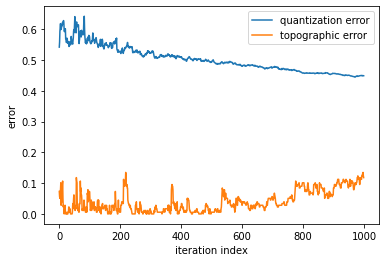

In [176]:
# iter에 따른 Error 시각화
max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(som_array))
    som.update(som_array[rand_i], som.winner(som_array[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(som_array))
    t_error.append(som.topographic_error(som_array))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

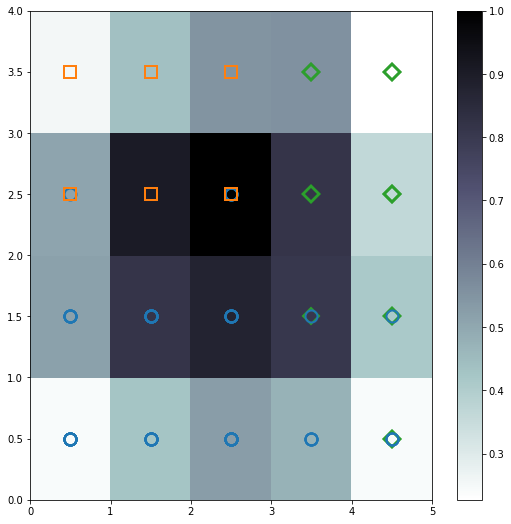

In [177]:
### SOM Visualization
plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(som_array):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[som_target[cnt]-1], markerfacecolor='None', 
             markeredgecolor=colors[som_target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

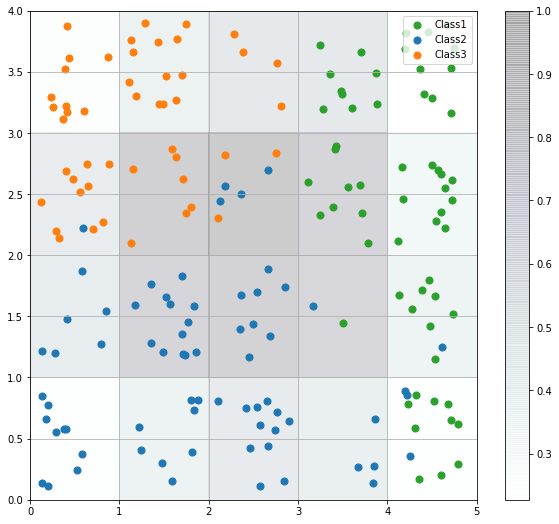

In [178]:
label_names = {0:'Class1', 1:'Class2', 2:'Class3'}

w_x, w_y = zip(*[som.winner(d) for d in som_array])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(som_target):
    idx_target = som_target==c
    plt.scatter(w_x[idx_target] + .5 + (np.random.rand(np.sum(idx_target)) - .5) * .8,
                w_y[idx_target] + .5 + (np.random.rand(np.sum(idx_target)) -.5) *.8, s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

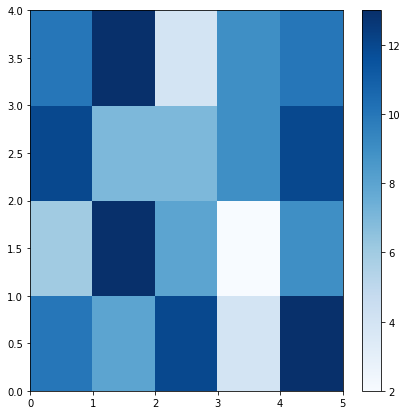

In [179]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(som_array)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

In [180]:
import matplotlib.gridspec as gridspec

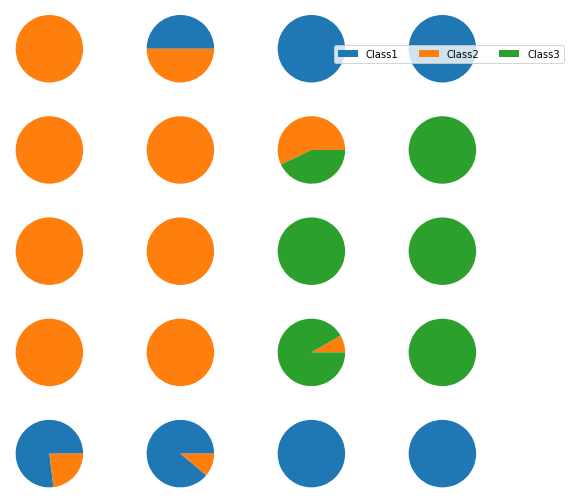

In [181]:
labels_map = som.labels_map(som_array, [label_names[t] for t in som_target.values])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[m_neurons-1-position[0], position[1]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(2, 3), ncol=3)
plt.show()

### (9) Spectral clustering
- 샘플 사이 유사도 행렬을 받아 저차원 임베딩 (차원축소)
- 저차원 공간에서 군집 알고리즘 사용 (K-means)
- 샘플 개수가 많거나, 클러스터 크기가 다르면 성능 저하

In [182]:
from sklearn.cluster import SpectralClustering

In [183]:
x, y = make_circles(n_samples=100, shuffle=True, noise=0.05, random_state=0, factor=0.5)
cluster_df = pd.DataFrame(x, columns=['f1', 'f2'])
cluster_df['target'] = y

In [184]:
sc1 = SpectralClustering(n_clusters=2, gamma=10, random_state=42)
sc1.fit(x)

sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(x)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [185]:
np.percentile(sc1.affinity_matrix_, 95)

0.6062259936328364

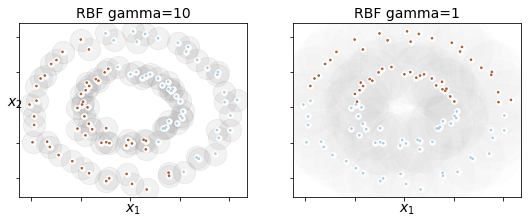

In [186]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plt.scatter(x[:, 0], x[:, 1], marker='o', s=500, c='gray', cmap="Paired", alpha=0.1)
plt.scatter(x[:, 0], x[:, 1], marker='o', s=30, c='w')
plt.scatter(x[:, 0], x[:, 1], marker='.', s=10, c=sc1.labels_, cmap="Paired")
plt.xlabel("$x_1$", fontsize=14)
plt.tick_params(labelbottom=False)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelleft=False)
plt.title("RBF gamma={}".format(sc1.gamma), fontsize=14)

plt.subplot(122)
plt.scatter(x[:, 0], x[:, 1], marker='o', s=4000, c='gray', cmap="Paired", alpha=0.01)
plt.scatter(x[:, 0], x[:, 1], marker='o', s=30, c='w')
plt.scatter(x[:, 0], x[:, 1], marker='.', s=10, c=sc2.labels_, cmap="Paired")
plt.xlabel("$x_1$", fontsize=14)
plt.tick_params(labelbottom=False)
plt.tick_params(labelleft=False)
plt.title("RBF gamma={}".format(sc2.gamma), fontsize=14)
plt.show()